In [1]:
%pylab inline
img_rows, img_cols = 28, 28

arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Populating the interactive namespace from numpy and matplotlib
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


8

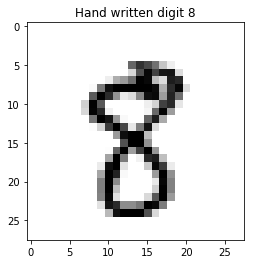

In [2]:
N=46
imshow(x_train[N], cmap='gray_r')
_ = title('Hand written digit '+str(y_train[N]))
y_train[N]

In [3]:
## ASSIGNMENT 1

## define matrix of absolute elements
def _absM(a,b):
    return abs(a-b)

## define d_infty
def _Dinfty(a,b):
    return _absM(a,b).max()

## define d_one
def _D1(a,b):
    return _absM(a,b).sum()

## define d_two
def _D2(a,b):
    return sqrt(square(_absM(a,b)).sum())

In [4]:
#_Dinfty(x_train[0],x_train[3])
_D1(x_train[0],x_train[3])
#_D2(x_train[0],x_train[3])

122.61177

In [5]:
## ASSIGNMENT 2

## this is a slow version of my_func
## which I use to compare the time gain
## w.r.t. the optimized version
## I expect time reduction by half when optimized
def my_func_slow(N,dist):
    X=x_train[:N]
    ret = zeros((N,N))
    for i in range(N):
        ret[i]= [ dist(X[i],B) for B in X ]
    return ret

## this is the optimised version
def my_func(N,dist):
    X=x_train[:N]
    ret = zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            ret[i][j]= dist(X[i],X[j])
    return ret+ret.T

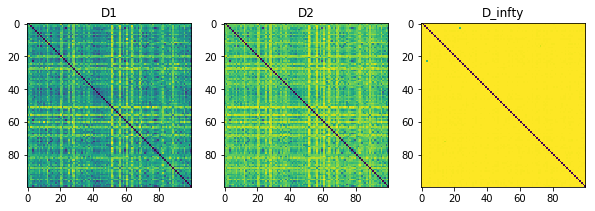

In [6]:
## ASSIGNMENT 3

import matplotlib.pyplot as plt

methods = [_D1,_D2,_Dinfty]
names = {_D1:'D1',_D2:'D2',_Dinfty:'D_infty'}
fig, axs = plt.subplots(1,3,figsize=(10,6))
for ax, method in zip(axs, methods):
    ax.imshow(my_func(100,method),cmap='viridis')
    ax.set_title(names[method].capitalize())
plt.show()

In [7]:
## to measure time
import time

class Timer():
    def __enter__(self):
        self._t0 = time.perf_counter()
    
    def __exit__(self,type,value,traceback):
        self._t1 = time.perf_counter()
        print("Time spent: [%0.8f] secs" % (self._t1-self._t0))
    
with Timer():
    time.sleep(2)

Time spent: [2.00219411] secs


In [8]:
## ASSIGNMENT 4 and 5
## precompute heavy part of the computation

N = 1600
distances = [_D1,_D2,_Dinfty]

with Timer():
    methods = []
    for dist in distances:
        methods.append(my_func(N,dist))

Time spent: [23.75519219] secs


In [203]:
## Uncomment these lines if you want to check
## my_func optimization
#with Timer():
 #   methods_slow = []
  #  for dist in distances:
   #     methods_slow.append(my_func_slow(N,dist))

Time spent: [46.14659301] secs


[[17.0, 17.0, 58.0],
 [14.5, 13.5, 52.0],
 [15.0, 13.5, 44.25],
 [14.5, 12.875, 40.0],
 [10.25, 9.375, 36.9375]]


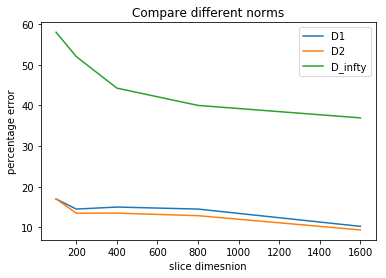

In [10]:
dims = [100,200,400,800,1600]
errors = []

## computation of the relative errors
for num in dims:
    loc_errors=[]
    for matrix in methods:
        error_counter = 0.
        for i in range(num):
            M = matrix[i:i+1][0][:num]
            MM = delete(M,i)
            arg = argmin(MM) + int(argmin(MM)>=i)
            digit = y_train[arg]
            if y_train[i] != digit:
                error_counter +=1
        loc_errors.append(error_counter*100/num)
    errors.append(loc_errors)
    
from pprint import pprint    
pprint(errors)

for k in range(3):
    plt.plot(dims,[errors[i][k] for i in range(size(dims)) ],label=names[distances[k]])
plt.legend()
plt.xlabel('slice dimesnion')
plt.ylabel('percentage error')
plt.title('Compare different norms')
plt.show()

[[17.0, 17.0, 53.0],
 [14.5, 13.5, 52.5],
 [15.0, 13.5, 46.0],
 [14.5, 12.875, 42.875],
 [10.25, 9.375, 37.5625]]


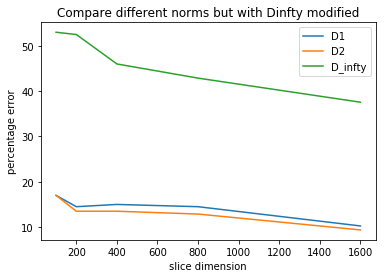

In [35]:
## computation of the relative errors
import random

errors2 = []

for num in dims:
    loc_errors=[]
    for matrix in methods:
        error_counter = 0.
        for i in range(num):
            M = matrix[i:i+1][0][:num]
            MM = delete(M,i)
            indices = where(MM==min(MM))[0]
            digits = [ y_train[j+int(j>=i)] for j in indices ]
            secure_random = random.SystemRandom()
            digit = secure_random.choice(digits)
            #digit = int(median(digits))
            #if y_train[i] not in digits:
            if y_train[i] != digit:
                error_counter +=1
        loc_errors.append(error_counter*100/num)
    errors2.append(loc_errors)
    
from pprint import pprint    
pprint(errors2)

for k in range(3):
    plt.plot(dims,[errors2[i][k] for i in range(size(dims)) ],label=names[distances[k]])
plt.legend()
plt.xlabel('slice dimension')
plt.ylabel('percentage error')
plt.title('Compare different norms but with Dinfty modified')
plt.show()

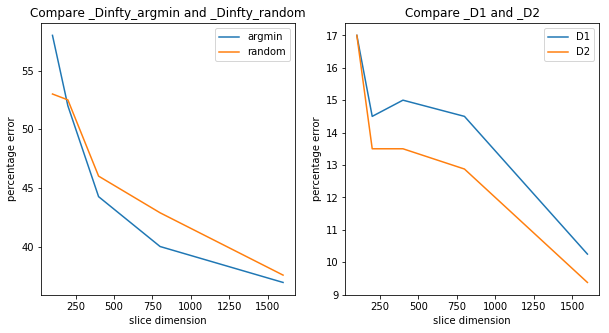

In [37]:
## compare performance of _Dinfty with two different error estimators
## and focus on the difference between D1 and D2
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

line1, = ax1.plot(dims,[errors[i][2] for i in range(size(dims))],label='argmin')
line2, = ax1.plot(dims,[errors2[i][2] for i in range(size(dims))],label='random')
ax1.legend()
ax1.set_title('Compare _Dinfty_argmin and _Dinfty_random')

line3, = ax2.plot(dims,[errors[i][0] for i in range(size(dims))],label='D1')
line4, = ax2.plot(dims,[errors[i][1] for i in range(size(dims))],label='D2')
ax2.legend()
ax2.set_title('Compare _D1 and _D2')

ax1.set_xlabel('slice dimension')
ax1.set_ylabel('percentage error')
ax2.set_xlabel('slice dimension')
ax2.set_ylabel('percentage error')

plt.show()

In [38]:
## define the classify function for later usage
## uncomment the following line or set X before calling
def classify(z,dist):
    X = x_train[:1000]
    all_distances = [dist(z,x) for x in X]
    digit = y_train[argmin(all_distances)]
    
    return digit

In [39]:
## test x_test angainst y_test with the distance D2
## notice that, for consistency, if you test x_train vs y_train
## you should get 0.000 errors with any norm: try it!

def my_test(X,Y,dist):
    errors = 0.
    test_range = 1000
    Tx = X[:test_range]
    Ty = Y[:test_range]
    for i in range(test_range):
        candidate = classify(Tx[i],dist)
        if candidate != Ty[i]:
            errors += 1
    errors = errors*100/test_range
    print("percentage error: %0.5f" % errors)

In [40]:
with Timer():
    my_test(x_test,y_test,_D2)

percentage error: 17.20000
Time spent: [7.01256788] secs


In [ ]:
## ASSIGNMENT 6